# Analysis of Glioblastoma
### Data source
This dataset was obtained from [Kaggle](https://www.kaggle.com/datasets/tanshihjen/clinical-gliomagrading)
### Data description
This dataset, derived from the Cancer Genome Atlas (TCGA) Project which is funded by the National Cancer Institute (NCI), is focused on the classification of glioma.  Glioma is the most prevalent type of brain tumor.  The gliomas are graded as Lower-Grade Gliomas (LGG) and Glioblastoma Multiforme (GBM).  Additionally, the LGG gliomas are further sub-classed with a Primary Diagnosis.  The grading is based on histological and imaging criteria.

The dataset includes records for a set of patients and includes demographic and mutated gene information for each patient.

### Project goal
The goal of the dataset and this project is to develop a machine learning model that can utilize the demographic and mutated gene information to predict the grading of the glioma as well as the sub-classed primary diagnosis.
## Accessing data and initial view

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import Birch
from sklearn.cluster import MiniBatchKMeans
import itertools
from collections import Counter
import time
from tabulate import tabulate

In [41]:
df_csv = pd.read_csv("glioma_TCGA_GBM_LGG_Mutations_all.csv")
df = df_csv.sample(len(df_csv))

In [42]:
print(df.head())
print(df.info())

    Grade   Project       Case_ID  Gender   Age_at_diagnosis  \
631   GBM  TCGA-GBM  TCGA-76-6286    Male  60 years 258 days   
733   GBM  TCGA-GBM  TCGA-76-6663  Female   44 years 55 days   
604   GBM  TCGA-GBM  TCGA-27-2524    Male  56 years 101 days   
775   GBM  TCGA-GBM  TCGA-28-1757    Male  71 years 257 days   
588   GBM  TCGA-GBM  TCGA-76-4928  Female  85 years 221 days   

    Primary_Diagnosis   Race         IDH1         TP53         ATRX  ...  \
631      Glioblastoma  white  NOT_MUTATED      MUTATED  NOT_MUTATED  ...   
733      Glioblastoma  white  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  ...   
604      Glioblastoma  white  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  ...   
775      Glioblastoma  white  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  ...   
588      Glioblastoma  white  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  ...   

           FUBP1          RB1       NOTCH1         BCOR        CSMD3  \
631  NOT_MUTATED      MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED   
733  NOT_MUTAT

### Exploratory Data Analysis
The dataset has 826 patients (samples) and 26 columns.  Of the 26 columns, 20 are mutated gene indicators.

There are no missing values that need to be addressed.

The Age_at_diagnosis feature is formed as a string with years and days such as "5 years 172 days".  Five samples have a placeholder string '--' for the Age_at_diagnosis and these are removed.

In [43]:
# Check for missing values (NaNs)
print("Data has", df.isna().sum().sum(), "NaNs")
# Drop rows with invalid Age string
print(len(df[df.Age_at_diagnosis == '--']), "rows have invalid values")
df.drop(df[df.Age_at_diagnosis == '--'].index, inplace=True)
df_LGG = df.drop(df[df.Grade == 'GBM'].index).copy()

# Use only the LGG data
useOnlyLGG = False
if useOnlyLGG == True:
    df = df_LGG

Data has 0 NaNs
5 rows have invalid values


### Labeling Data
The Grade and Primary Diagnosis columns can be treated as labels where Grade is LGG or GBM.  Within the LGG graded samples, there are five Primary Diagnoses.  These columns are converted to category types to be used for evaluating the models later.  These columns are also separated from the rest so that the remaining columns can be treated as the X data frame in modeling.

In [5]:
df_labels = df[['Grade', 'Primary_Diagnosis']].copy()
df_labels['Grade'] = df_labels['Grade'].astype('category')
df_labels['gradeID'] = df_labels['Grade'].cat.codes
grade_dict = dict(enumerate(df_labels['Grade'].cat.categories))
num_grades = len(grade_dict)
grade_names = np.unique(df_labels['Grade'])
print("Dictionary of grade labels", grade_dict)

df_labels['Primary_Diagnosis'] = df_labels['Primary_Diagnosis'].astype('category')
df_labels['diagID'] = df_labels['Primary_Diagnosis'].cat.codes
diag_dict = dict(enumerate(df_labels['Primary_Diagnosis'].cat.categories))
num_primary_diags = len(diag_dict)
diag_names = np.unique(df_labels['Primary_Diagnosis'])
print("Dictionary of diagnosis labels", diag_dict)

Dictionary of grade labels {0: 'GBM', 1: 'LGG'}
Dictionary of diagnosis labels {0: 'Astrocytoma, NOS', 1: 'Astrocytoma, anaplastic', 2: 'Glioblastoma', 3: 'Mixed glioma', 4: 'Oligodendroglioma, NOS', 5: 'Oligodendroglioma, anaplastic'}


The Age_at_diagnosis feature is converted to a floating point value of years.

In [6]:
def convert_age(ageStr):
    lst = ageStr.split(" ")
    if len(lst) == 2: age = int(lst[0])
    if len(lst) == 4: age = int(lst[0]) + int(lst[2])/365
    return age

df['Age'] = df['Age_at_diagnosis'].apply(lambda x: convert_age(x))

The feature set is formed by removing the project information and the labels.

In [7]:
df_X = df.drop(['Grade', 'Project', 'Case_ID', 'Age_at_diagnosis', 'Primary_Diagnosis'], axis=1)
df_X.head()

,Gender,Race,IDH1,TP53,ATRX,PTEN,EGFR,CIC,MUC16,PIK3CA,...,RB1,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA,Age
410,Female,white,MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,MUTATED,NOT_MUTATED,38.035616
637,Male,white,NOT_MUTATED,MUTATED,NOT_MUTATED,NOT_MUTATED,MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,...,MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,86.021918
23,Male,white,NOT_MUTATED,MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,66.835616
548,Female,white,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,52.265753
297,Female,white,MUTATED,MUTATED,MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,32.457534


A second feature set is created with just the mutated gene data and the demographic data removed (gender, race, age).

In [8]:
# Convert all features except Age to categorical
# Change all 'object' columns type 'category'
df_X[df_X.select_dtypes(['object']).columns] = df_X.select_dtypes(['object']).apply(lambda x: x.astype('category'))
df_X2 = df_X.drop(['Gender', 'Race', 'Age'], axis=1)
df_X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 857 entries, 410 to 181
Data columns (total 23 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   Gender   857 non-null    category
 1   Race     857 non-null    category
 2   IDH1     857 non-null    category
 3   TP53     857 non-null    category
 4   ATRX     857 non-null    category
 5   PTEN     857 non-null    category
 6   EGFR     857 non-null    category
 7   CIC      857 non-null    category
 8   MUC16    857 non-null    category
 9   PIK3CA   857 non-null    category
 10  NF1      857 non-null    category
 11  PIK3R1   857 non-null    category
 12  FUBP1    857 non-null    category
 13  RB1      857 non-null    category
 14  NOTCH1   857 non-null    category
 15  BCOR     857 non-null    category
 16  CSMD3    857 non-null    category
 17  SMARCA4  857 non-null    category
 18  GRIN2A   857 non-null    category
 19  IDH2     857 non-null    category
 20  FAT4     857 non-null    category
 

To assist wtih model building, the boolean gene mutation features are encoded and the age is scaled.

In [9]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

catCols = df_X.select_dtypes("category").columns
catCols = list(set(catCols))
numCols = ['Age']
ct = make_column_transformer(
    (OneHotEncoder(), catCols),
    (StandardScaler(), numCols))
df_X_encoded = ct.fit_transform(df_X)
df_X_encoded.shape

(857, 48)

In [10]:
catCols = df_X2.select_dtypes("category").columns
catCols = list(set(catCols))
ct = make_column_transformer(
    (OneHotEncoder(), catCols))
df_X2_encoded = ct.fit_transform(df_X2)
df_X2_encoded.shape

(857, 40)

In [11]:
pd.DataFrame(df_X_encoded).head()

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,-0.819713
1,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,2.232149
2,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.011927
3,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.085304
4,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,-1.174471


# Building and Optimizing Models
## Principal Component Analysis
Here is an initial view with a feature reduction to two components.  The data appears to have four banded clusters.  However, the separation of points by the LGG/GBM grade follows the opposite axis.

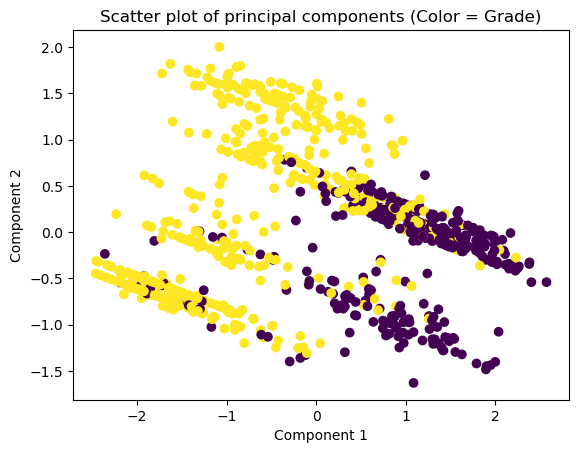

In [12]:
principal_2pc = PCA(n_components = 2)
principal_2pc.fit(df_X_encoded)
df_Xscaled2 = principal_2pc.transform(df_X_encoded)  # Result: 2 dimension array with 64 rows
plt.scatter(df_Xscaled2[:,0], df_Xscaled2[:,1], c=df_labels.gradeID)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("Scatter plot of principal components (Color = Grade)")
plt.show()

## Optimization of PCA with Explained Variance Target
The following code and graph show that only about half of the components are explaining some of the variance.  A cut-off of 90% was used for the explained variance target leading to a selection of 14 components.

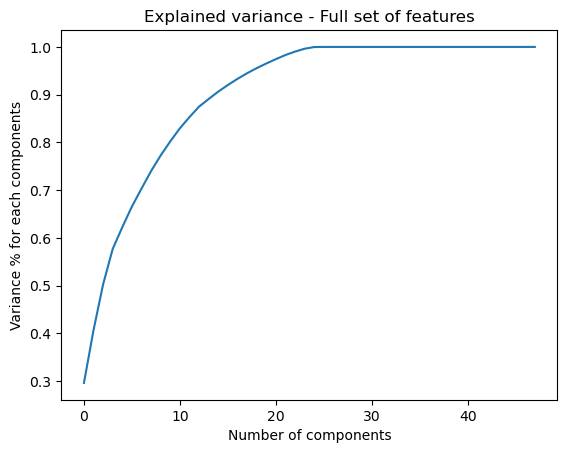

In [13]:
principal = PCA()
principal.fit(df_X_encoded)
df_X_PCA = principal.transform(df_X_encoded)

#plotting the cumulative summation of the explained variance
plt.figure()
plt.plot(np.cumsum(principal.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Variance % for each components')
plt.title('Explained variance - Full set of features')
plt.show()

In [14]:
explained_target = 0.9 # % of variance explained by PCA
pca_index = np.where(np.cumsum(principal.explained_variance_ratio_) > explained_target)[0][0]
print("Number of PCA components to use:", pca_index)
finalPCA = PCA(n_components = pca_index)
finalPCA.fit(df_X_encoded)
X_pca = finalPCA.transform(df_X_encoded)

Number of PCA components to use: 14


## Finding the "elbow" for k-Means clustering
The following graph shows that a sizeable drop in the sum of squared distances occurs when moving to two clusters.  A somewhat less drop occurs with three clusters, and then the drop starts flattening out.

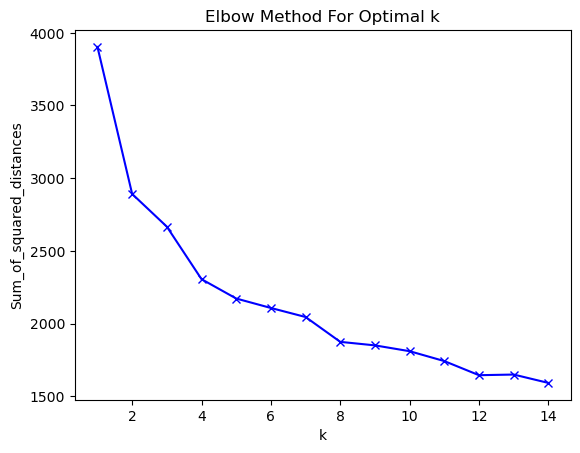

In [15]:
from sklearn.cluster import KMeans
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k, max_iter=1000)
    km = km.fit(X_pca)
    Sum_of_squared_distances.append(km.inertia_)
#Visualing the plot
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

The following set of graphs show how the samples are grouped into 2, 3, 4, and 6 clusters.  Beyond two clusters, there is significant overlap between the clusters.

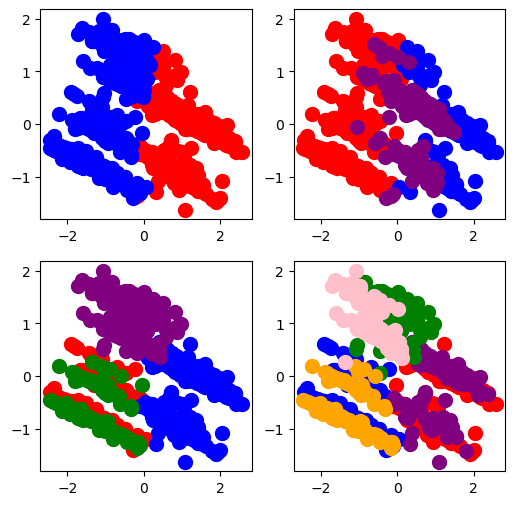

In [16]:
def plot_kmeans_clusters(n_clusters, myPlt):
    kmeans_plot = KMeans(n_clusters=n_clusters, max_iter=1000).fit(X_pca)
    y_kmeans=kmeans_plot.labels_
    myPlt.scatter(X_pca[y_kmeans==0,0],X_pca[y_kmeans==0,1],s=100,c='red',label='Cluster1')
    if n_clusters > 1: myPlt.scatter(X_pca[y_kmeans==1,0],X_pca[y_kmeans==1,1],s=100,c='blue',label='Cluster2')
    if n_clusters > 2: myPlt.scatter(X_pca[y_kmeans==2,0],X_pca[y_kmeans==2,1],s=100,c='purple',label='Cluster3')
    if n_clusters > 3: myPlt.scatter(X_pca[y_kmeans==3,0],X_pca[y_kmeans==3,1],s=100,c='green',label='Cluster4')
    if n_clusters > 4: myPlt.scatter(X_pca[y_kmeans==4,0],X_pca[y_kmeans==4,1],s=100,c='orange',label='Cluster5')
    if n_clusters > 5: myPlt.scatter(X_pca[y_kmeans==5,0],X_pca[y_kmeans==5,1],s=100,c='pink',label='Cluster5')
    #myPlt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],s=300,c='yellow',label='Centroids')
    #myPlt.set_title(str.join(n_clusters, 'Clusters of data'))

fig=plt.figure(figsize=[6,6])
ax0=fig.add_subplot(221)
ax1=fig.add_subplot(222)
ax2=fig.add_subplot(223)
ax3=fig.add_subplot(224)
plot_kmeans_clusters(2, ax0)
plot_kmeans_clusters(3, ax1)
plot_kmeans_clusters(4, ax2)
plot_kmeans_clusters(6, ax3)


# Back to Building Models
The reduced feature set (without demographic data) is run through PCA to determine how many features could be further reduced.

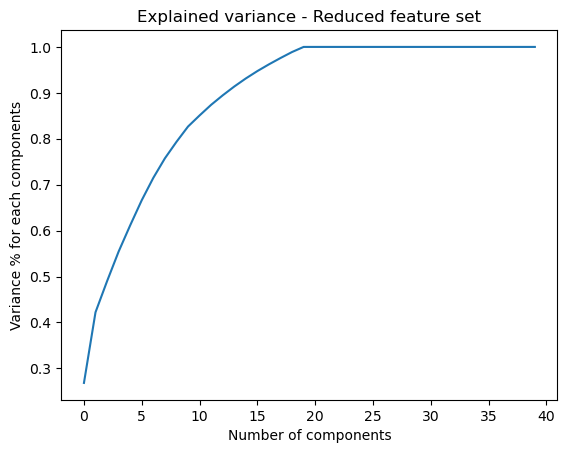

In [17]:
principal2 = PCA()
principal2.fit(df_X2_encoded)
df_X2_PCA = principal2.transform(df_X2_encoded)

#plotting the cumulative summation of the explained variance
plt.figure()
plt.plot(np.cumsum(principal2.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Variance % for each components')
plt.title('Explained variance - Reduced feature set')
plt.show()

In [18]:
pca_index = np.where(np.cumsum(principal2.explained_variance_ratio_) > explained_target)[0][0]
print("Number of PCA components to use:", pca_index)
finalPCA2 = PCA(n_components = pca_index)
finalPCA2.fit(df_X2_encoded)
X2_pca = finalPCA2.transform(df_X2_encoded)

Number of PCA components to use: 13


### Helper functions for model testing

In [19]:
# Need to map the model's category IDs back to the original category IDs
def label_permute_compare(yt, yp, n=6):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order, accuracy, chosen predicted labels. 
    Example output: (3, 4, 1, 2, 0), 0.74 
    """
    # yt is the true labels, yp is what the model came up with (predictions)
    bestOrder = 0
    bestAccuracy = 0
    bestYP = 0
    # Save off the total number of samples for the denominator later on
    numSamples = yt.shape[0]
    #print("numSamples:", numSamples)
    # Compute how many permutations there are
    perms = itertools.permutations(range(n)) # Returns: (0, 1, 2, 3, 4), (0, 1, 2, 4, 3), (0, 1, 3, 2, 4)...
    for perm in perms:
        #print("perm:", perm)
        tmpYP=[]
        for i in range(numSamples):
            if yp[i] < 0:
                #print("Warning: negative yp[i]")
                pass
            elif yp[i] > n:
                #print("yp[i] too high:", yp[i])
                pass
            else:
                tmpYP.append(perm[yp[i]])
        acc = accuracy_score(yt, tmpYP)
        #print("acc:", acc)
        if acc > bestAccuracy:
            bestAccuracy = acc
            bestOrder = perm
            bestYP = tmpYP
    #print("Best order:", bestOrder, "Best accuracy:", bestAccuracy)
    return bestOrder, bestAccuracy, bestYP

In [20]:
def compare_and_cm(trueLabels, trueIDs, predIDs, label_names, n_clusters, showCM, headLines=0):
    # trueLabels = df_labels.Grade
    # trueIDs = df_labels.gradeID
    # predIDs = y_kmeans or kmeans.labels_
    # label_names = grade_names
    labelorder, acc, bestYP = label_permute_compare(trueIDs, predIDs, n_clusters)
    print(labelorder, acc)
    if headLines > 0:
        print(pd.DataFrame(data = {'true': trueLabels, 'trueID':trueIDs, 'pred':label_names[bestYP], 'predID':predIDs}).head(headLines))
    if showCM == True:
        cm = confusion_matrix(trueLabels, label_names[bestYP])
        plt.figure(figsize=(4,4))
        sns.heatmap(cm, cmap='Greens', annot=True, fmt='.0f', xticklabels = label_names, yticklabels = label_names)
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted Categories")
        plt.ylabel("Actual Categories")

The k-Means, Mini Batch k-Means, Agglomerative Clustering, and Birch methods are dimension reduction techniques and so don't natively have a scoring function.

In [21]:
# Create a custom scoring function for dimension reduction
# See https://scikit-learn.org/stable/modules/model_evaluation.html#scoring
# estimator is the model that should be evaluated, X is validation data, and y is the ground truth target for X (in the supervised case)
def DR_scoring(estimator, X, y):
    preds = estimator.labels_
    labelorder, acc, bestYP = label_permute_compare(y, preds, 6)
    return acc

## Clustering by Grade
A series of models are created and tested to see how accurately they can predict the LGG / GBM grade.  The series includes k-Means, Agglomerative, Birch, and Mini Batch k-Means.  Each of these was tested with a basic, initial configuration and cross-validated using the DB_scoring() function above.  These methods were attempted to be optimized using GridSearchCV.

Note: An attempt was made to utilize DBSCAN clustering.  However, it does not allow for a number of clusters to be pre-specified and was thus abandoned.
### Using K-Means

(1, 0) 0.8261376896149358
Cross validation mean accuracy: 0.5274 with std: 0.0266    All scores: [0.5    0.5581 0.5614 0.5088 0.5088]


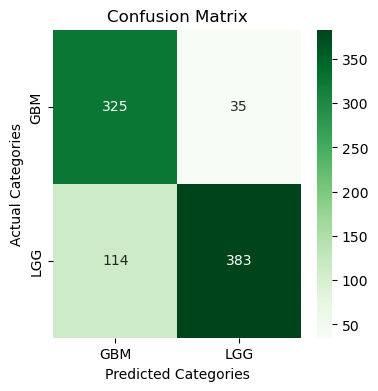

In [22]:
compResults = pd.DataFrame(columns = ['Method', 'CrossVal Mean Accuracy'])

if useOnlyLGG == False:
    n_clusters = num_grades
    kmeans = KMeans(n_clusters=n_clusters, max_iter=1000).fit(X_pca)
    compare_and_cm(df_labels.Grade, df_labels.gradeID, kmeans.labels_, grade_names, n_clusters, True)
    scores = cross_val_score(kmeans, X_pca, df_labels.gradeID, cv=5, scoring=DR_scoring)
    scores = np.round(scores, 4)
    print("Cross validation mean accuracy:", np.round(np.mean(scores), 4), "with std:", np.round(np.std(scores), 4), "   All scores:", scores)
    compResults.at[0, 'Method'] = 'k-Means'
    compResults.at[0, 'CrossVal Mean Accuracy'] = np.round(np.mean(scores), 4)

else:
    print("Only examining LGG patients")

### By Grade:  Using Agglomerative Clustering

(1, 0) 0.8599766627771295
Cross validation mean accuracy: 0.5391 with std: 0.0232    All scores: [0.5233 0.5523 0.5789 0.5205 0.5205]


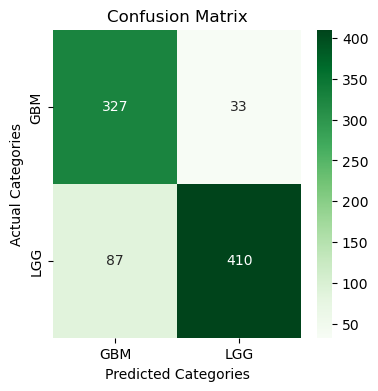

In [23]:
n_clusters = num_grades
aggC = AgglomerativeClustering(n_clusters = n_clusters, metric='euclidean', linkage='ward').fit(X_pca)
compare_and_cm(df_labels.Grade, df_labels.gradeID, aggC.labels_, grade_names, n_clusters, True)
scores = cross_val_score(aggC, X_pca, df_labels.gradeID, cv=5, scoring=DR_scoring)
scores = np.round(scores, 4)
print("Cross validation mean accuracy:", np.round(np.mean(scores), 4), "with std:", np.round(np.std(scores), 4), "   All scores:", scores)
compResults.at[1, 'Method'] = 'Agglomerative'
compResults.at[1, 'CrossVal Mean Accuracy'] = np.round(np.mean(scores), 4)

### Grid Search to Optimize Agglomerative Clustering

In [24]:
n_clusters = num_grades
aggC = AgglomerativeClustering(n_clusters = n_clusters)
search_parms = [{
    'linkage': ['complete', 'average', 'single'],
    'metric' : ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']
}]

gscv_AC = GridSearchCV(estimator=aggC, param_grid = search_parms, scoring = DR_scoring, cv=5, verbose=0)
startTime = time.time()
gscv_AC.fit(X_pca, df_labels.gradeID)
print("Execution time:", round((time.time() - startTime)/60, 1), "minutes")

Execution time: 0.6 minutes


In [25]:
results = (pd.DataFrame(gscv_AC.cv_results_))[['params', 'mean_test_score', 'rank_test_score']].copy()
print(tabulate(results.sort_values(by='rank_test_score').iloc[:5,:], 
      headers='keys', tablefmt='rounded_grid', showindex=False, maxcolwidths=[60, None, None]))
compResults.at[2, 'Method'] = 'Optimized Agglomerative'
compResults.at[2, 'CrossVal Mean Accuracy'] = np.round(results.sort_values(by='rank_test_score').iloc[0,1], 4)

╭────────────────────────────────────────────────┬───────────────────┬───────────────────╮
│ params                                         │   mean_test_score │   rank_test_score │
├────────────────────────────────────────────────┼───────────────────┼───────────────────┤
│ {'linkage': 'single', 'metric': 'l1'}          │          0.579967 │                 1 │
├────────────────────────────────────────────────┼───────────────────┼───────────────────┤
│ {'linkage': 'single', 'metric': 'manhattan'}   │          0.579967 │                 1 │
├────────────────────────────────────────────────┼───────────────────┼───────────────────┤
│ {'linkage': 'complete', 'metric': 'l1'}        │          0.578805 │                 3 │
├────────────────────────────────────────────────┼───────────────────┼───────────────────┤
│ {'linkage': 'complete', 'metric': 'manhattan'} │          0.578805 │                 3 │
├────────────────────────────────────────────────┼───────────────────┼───────────────────┤

### DBSCAN for Grade Clustering

In [27]:
# NOTE: DBSCAN does not allow for the number of clusters to be specified, so it doesn't work for this application
#n_clusters = num_grades
#dbscan = DBSCAN(eps=1.405, min_samples=5, algorithm='ball_tree').fit(X_pca)
#print(pd.DataFrame(dbscan.labels_).describe())
#compare_and_cm(df_labels.Grade, df_labels.gradeID, dbscan.labels_, grade_names, n_clusters, True)
#scores = cross_val_score(dbscan, X_pca, df_labels.gradeID, cv=5, scoring=DR_scoring)
#print("Cross validation mean accuracy:", np.mean(scores))

### Birch for Grade Clustering

(1, 0) 0.823803967327888
Cross validation mean accuracy: 0.5391 with std: 0.0203    All scores: [0.5407 0.5523 0.5673 0.5263 0.5088]


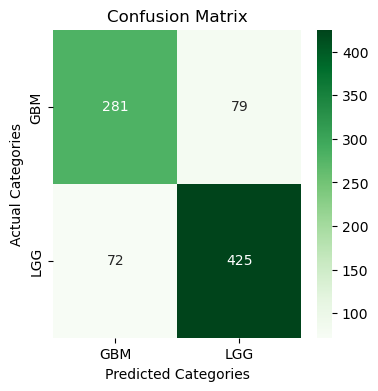

In [28]:
n_clusters = num_grades
brc = Birch(n_clusters = n_clusters).fit(X_pca)
compare_and_cm(df_labels.Grade, df_labels.gradeID, brc.labels_, grade_names, n_clusters, True)
scores = cross_val_score(brc, X_pca, df_labels.gradeID, cv=5, scoring=DR_scoring)
scores = np.round(scores, 4)
print("Cross validation mean accuracy:", np.round(np.mean(scores), 4), "with std:", np.round(np.std(scores), 4), "   All scores:", scores)
compResults.at[3, 'Method'] = 'Birch'
compResults.at[3, 'CrossVal Mean Accuracy'] = np.round(np.mean(scores), 4)

### Mini Batch k-Means for Grade Clustering

(1, 0) 0.7736289381563594
Cross validation mean accuracy: 0.5344 with std: 0.0231    All scores: [0.5174 0.564  0.5614 0.5146 0.5146]


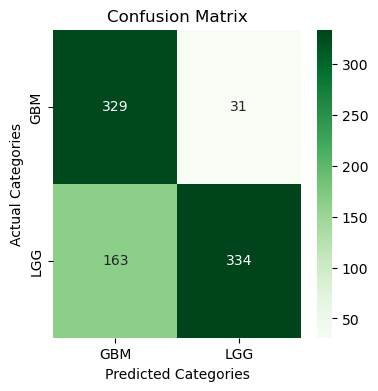

In [29]:
n_clusters = num_grades
kmeans = MiniBatchKMeans(n_clusters=n_clusters, init="k-means++", max_iter=1000, batch_size=100, n_init=10, reassignment_ratio=0.1).fit(X_pca)
compare_and_cm(df_labels.Grade, df_labels.gradeID, kmeans.labels_, grade_names, n_clusters, True)
scores = cross_val_score(kmeans, X_pca, df_labels.gradeID, cv=5, scoring=DR_scoring)
scores = np.round(scores, 4)
print("Cross validation mean accuracy:", np.round(np.mean(scores), 4), "with std:", np.round(np.std(scores), 4), "   All scores:", scores)
compResults.at[4, 'Method'] = 'Mini Batch k-Means'
compResults.at[4, 'CrossVal Mean Accuracy'] = np.round(np.mean(scores), 4)

### Grid Search to Optimize Mini Batch k-Means

In [30]:
n_clusters = num_grades
kmeans = MiniBatchKMeans(n_clusters=n_clusters, init="k-means++", max_iter=1000, batch_size=100, n_init=10, reassignment_ratio=0.1).fit(X_pca)
search_parms = [{
    'max_iter': [100, 1000, 5000],
    'batch_size' : [10, 100, 1000],
    'n_init' : [10, 100],
    'reassignment_ratio' : [0.01, 0.05, 0.1],
}]

gscv_MB = GridSearchCV(estimator=kmeans, param_grid = search_parms, scoring = DR_scoring, cv=5, verbose=0)
startTime = time.time()
gscv_MB.fit(X_pca, df_labels.gradeID)
print("Execution time:", round((time.time() - startTime)/60, 1), "minutes")

Execution time: 2.9 minutes


In [31]:
results = (pd.DataFrame(gscv_MB.cv_results_))[['params', 'mean_test_score', 'rank_test_score']].copy()
print(tabulate(results.sort_values(by='rank_test_score').iloc[:5,:], 
      headers='keys', tablefmt='rounded_grid', showindex=False, maxcolwidths=[80, None, None]))
compResults.at[5, 'Method'] = 'Optimized Mini Batch k-Means'
compResults.at[5, 'CrossVal Mean Accuracy'] = np.round(results.sort_values(by='rank_test_score').iloc[0,1], 4)

╭──────────────────────────────────────────────────────────────────────────────────┬───────────────────┬───────────────────╮
│ params                                                                           │   mean_test_score │   rank_test_score │
├──────────────────────────────────────────────────────────────────────────────────┼───────────────────┼───────────────────┤
│ {'batch_size': 10, 'max_iter': 5000, 'n_init': 10, 'reassignment_ratio': 0.1}    │          0.534387 │                 1 │
├──────────────────────────────────────────────────────────────────────────────────┼───────────────────┼───────────────────┤
│ {'batch_size': 100, 'max_iter': 5000, 'n_init': 10, 'reassignment_ratio': 0.01}  │          0.533259 │                 2 │
├──────────────────────────────────────────────────────────────────────────────────┼───────────────────┼───────────────────┤
│ {'batch_size': 1000, 'max_iter': 1000, 'n_init': 100, 'reassignment_ratio':      │          0.533245 │                 3 │


## Summary of Clustering for Grade
None of the models were able to achieve an acceptable level of accuracy.  Most were around 55% which is almost to same as pure guessing.  It should be noted that some runs had accuracy levels greater than 85% but this was probably due to random chance.

In [32]:
print(tabulate(compResults, headers='keys', tablefmt='rounded_grid', showindex=False, maxcolwidths=[None, None]))

╭──────────────────────────────┬──────────────────────────╮
│ Method                       │   CrossVal Mean Accuracy │
├──────────────────────────────┼──────────────────────────┤
│ k-Means                      │                   0.5274 │
├──────────────────────────────┼──────────────────────────┤
│ Agglomerative                │                   0.5391 │
├──────────────────────────────┼──────────────────────────┤
│ Optimized Agglomerative      │                   0.58   │
├──────────────────────────────┼──────────────────────────┤
│ Birch                        │                   0.5391 │
├──────────────────────────────┼──────────────────────────┤
│ Mini Batch k-Means           │                   0.5344 │
├──────────────────────────────┼──────────────────────────┤
│ Optimized Mini Batch k-Means │                   0.5344 │
╰──────────────────────────────┴──────────────────────────╯


## Clustering by Primary Diagnosis
Given the poor performance in clustering around the LGG/GBM grade, there isn't a lot of hope that the models will do better for the Primary Diagnosis.  Indeed, with k-Means, the cross validation acccuracy is 32% and the optimized Agglomerative Clustering score is 42%.
### Using K-Means

(1, 0, 3, 5, 4, 2) 0.38156359393232203
Cross validation mean accuracy: 0.2602 with std: 0.0189    All scores: [0.2674 0.2384 0.2924 0.2573 0.2456]


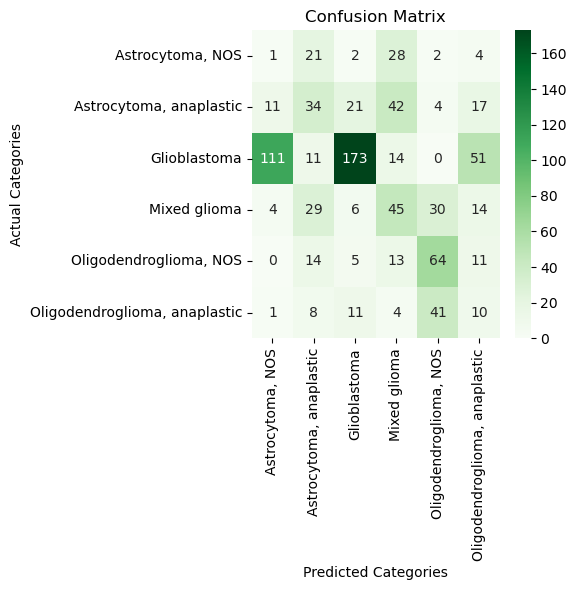

In [33]:
n_clusters = num_primary_diags
kmeans = KMeans(n_clusters=n_clusters, max_iter=1000).fit(X_pca)
compare_and_cm(df_labels.Primary_Diagnosis, df_labels.diagID, kmeans.labels_, diag_names, n_clusters, True)
scores = cross_val_score(kmeans, X_pca, df_labels.diagID, cv=5, scoring=DR_scoring)
scores = np.round(scores, 4)
print("Cross validation mean accuracy:", np.round(np.mean(scores), 4), "with std:", np.round(np.std(scores), 4), "   All scores:", scores)

### Comparing performance of k-Means using various X datasets

In [34]:
n_clusters = num_primary_diags
kmeans = KMeans(n_clusters=n_clusters, max_iter=1000).fit(df_X_encoded)
scores = np.round(cross_val_score(kmeans, X_pca, df_labels.diagID, cv=5, scoring=DR_scoring), 4)
print("df_X_encoded:  Cross validation mean accuracy:", np.round(np.mean(scores), 4), "with std:", np.round(np.std(scores), 4), "   All scores:", scores)
kmeans = KMeans(n_clusters=n_clusters, max_iter=1000).fit(X_pca)
scores = np.round(cross_val_score(kmeans, X_pca, df_labels.diagID, cv=5, scoring=DR_scoring), 4)
print("X_pca:         Cross validation mean accuracy:", np.round(np.mean(scores), 4), "with std:", np.round(np.std(scores), 4), "   All scores:", scores)
kmeans = KMeans(n_clusters=n_clusters, max_iter=1000).fit(df_X2_encoded)
scores = np.round(cross_val_score(kmeans, X_pca, df_labels.diagID, cv=5, scoring=DR_scoring), 4)
print("df_X2_encoded: Cross validation mean accuracy:", np.round(np.mean(scores), 4), "with std:", np.round(np.std(scores), 4), "   All scores:", scores)
kmeans = KMeans(n_clusters=n_clusters, max_iter=1000).fit(X2_pca)
scores = np.round(cross_val_score(kmeans, X_pca, df_labels.diagID, cv=5, scoring=DR_scoring), 4)
print("X2_pca:        Cross validation mean accuracy:", np.round(np.mean(scores), 4), "with std:", np.round(np.std(scores), 4), "   All scores:", scores)

df_X_encoded:  Cross validation mean accuracy: 0.2567 with std: 0.0134    All scores: [0.2616 0.25   0.269  0.2339 0.269 ]
X_pca:         Cross validation mean accuracy: 0.2917 with std: 0.0061    All scores: [0.2965 0.2907 0.2924 0.2807 0.2982]
df_X2_encoded: Cross validation mean accuracy: 0.2707 with std: 0.0085    All scores: [0.2849 0.2616 0.2749 0.2632 0.269 ]
X2_pca:        Cross validation mean accuracy: 0.2707 with std: 0.032    All scores: [0.3023 0.2151 0.2982 0.2573 0.2807]


## Grid Search Optimization of Agglomerative Clustering for Primary Diagnosis

In [35]:
n_clusters = num_primary_diags
aggC = AgglomerativeClustering(n_clusters = n_clusters)
search_parms = [{
    'linkage': ['complete', 'average', 'single'],
    'metric' : ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']
}]

gscv = GridSearchCV(estimator=aggC, param_grid = search_parms, scoring = DR_scoring, cv=5, verbose=0)
startTime = time.time()
gscv.fit(X_pca, df_labels.diagID)
print("Execution time:", round((time.time() - startTime)/60, 1), "minutes")

Execution time: 0.7 minutes


In [36]:
results = (pd.DataFrame(gscv.cv_results_))[['params', 'mean_test_score', 'rank_test_score']].copy()
print(tabulate(results.sort_values(by='rank_test_score').iloc[:5,:], 
      headers='keys', tablefmt='rounded_grid', showindex=False, maxcolwidths=[60, None, None]))

╭──────────────────────────────────────────────┬───────────────────┬───────────────────╮
│ params                                       │   mean_test_score │   rank_test_score │
├──────────────────────────────────────────────┼───────────────────┼───────────────────┤
│ {'linkage': 'single', 'metric': 'cosine'}    │          0.42703  │                 1 │
├──────────────────────────────────────────────┼───────────────────┼───────────────────┤
│ {'linkage': 'single', 'metric': 'l1'}        │          0.424691 │                 2 │
├──────────────────────────────────────────────┼───────────────────┼───────────────────┤
│ {'linkage': 'single', 'metric': 'manhattan'} │          0.424691 │                 2 │
├──────────────────────────────────────────────┼───────────────────┼───────────────────┤
│ {'linkage': 'single', 'metric': 'euclidean'} │          0.423528 │                 4 │
├──────────────────────────────────────────────┼───────────────────┼───────────────────┤
│ {'linkage': 'single

# Comparison with Supervised Learning
The following supervised learning models will be employed to attempt to cluster by LGG/GBM grade:  Logistic Regression, Linear Support Vector Classifier, Stochastic Gradient Descent (SGD) Classifier

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier

In [38]:
# Classifying according to Grade
supervised_X = X2_pca # X_pca
def run_model(model):
    model.fit(supervised_X, df_labels.Grade)
    y_pred = model.predict(supervised_X)
    acc = accuracy_score(df_labels.Grade, y_pred)
    scores = cross_val_score(model, X = supervised_X, y = df_labels.Grade, scoring='accuracy', cv=5)
    return round(acc, 4), np.round(scores, 4)

lsvm_model = LinearSVC(dual=False, C = 1, loss = 'squared_hinge', max_iter=5000)
logreg = LogisticRegression(solver='lbfgs', max_iter=1000)
sgdc = SGDClassifier(penalty='elasticnet', max_iter=1000, tol=1e-3)

startTime = time.time()
reduced_results = pd.DataFrame(columns = ['Method', 'Mean Accuracy', 'CrossVal Mean Accuracy', 'CrossVal Std Accuracy'])
acc, scores = run_model(lsvm_model)
reduced_results.at[0, 'Method'] = 'LinearSVC'
reduced_results.at[0, 'Mean Accuracy'] = acc
reduced_results.at[0, 'CrossVal Mean Accuracy'] = np.mean(scores)
reduced_results.at[0, 'CrossVal Std Accuracy'] = np.std(scores)
acc, scores = run_model(logreg)
reduced_results.at[1, 'Method'] = 'Logistic Regression'
reduced_results.at[1, 'Mean Accuracy'] = acc
reduced_results.at[1, 'CrossVal Mean Accuracy'] = np.mean(scores)
reduced_results.at[1, 'CrossVal Std Accuracy'] = np.std(scores)
acc, scores = run_model(sgdc)
reduced_results.at[2, 'Method'] = 'SGD Classification'
reduced_results.at[2, 'Mean Accuracy'] = acc
reduced_results.at[2, 'CrossVal Mean Accuracy'] = np.mean(scores)
reduced_results.at[2, 'CrossVal Std Accuracy'] = np.std(scores)

print("Execution time:", round((time.time() - startTime)/60, 1), "minutes")
print("\nSupervised Learning classification according to LGG/GBM Grade")
from tabulate import tabulate  #  See https://pypi.org/project/tabulate/
print(tabulate(reduced_results.sort_values(['Method'], ascending=[True]), 
               headers='keys', tablefmt='rounded_grid', showindex=False))

Execution time: 0.0 minutes

Supervised Learning classification according to LGG/GBM Grade
╭─────────────────────┬─────────────────┬──────────────────────────┬─────────────────────────╮
│ Method              │   Mean Accuracy │   CrossVal Mean Accuracy │   CrossVal Std Accuracy │
├─────────────────────┼─────────────────┼──────────────────────────┼─────────────────────────┤
│ LinearSVC           │          0.8588 │                  0.85646 │               0.0188584 │
├─────────────────────┼─────────────────┼──────────────────────────┼─────────────────────────┤
│ Logistic Regression │          0.8623 │                  0.85878 │               0.0173568 │
├─────────────────────┼─────────────────┼──────────────────────────┼─────────────────────────┤
│ SGD Classification  │          0.8553 │                  0.84828 │               0.0281351 │
╰─────────────────────┴─────────────────┴──────────────────────────┴─────────────────────────╯


In [39]:
# Classifying according to Primary Diagnosis
supervised_X = X_pca # X_pca
def run_model(model):
    model.fit(supervised_X, df_labels.Primary_Diagnosis)
    y_pred = model.predict(supervised_X)
    acc = accuracy_score(df_labels.Primary_Diagnosis, y_pred)
    scores = cross_val_score(model, X = supervised_X, y = df_labels.Primary_Diagnosis, scoring='accuracy', cv=5)
    return round(acc, 4), np.round(scores, 4)

lsvm_model = LinearSVC(dual=False, C = 1, loss = 'squared_hinge', max_iter=5000)
logreg = LogisticRegression(solver='lbfgs', max_iter=1000)
sgdc = SGDClassifier(penalty='elasticnet', max_iter=1000, tol=1e-3)

startTime = time.time()
reduced_results = pd.DataFrame(columns = ['Method', 'Mean Accuracy', 'CrossVal Mean Accuracy', 'CrossVal Std Accuracy'])
acc, scores = run_model(lsvm_model)
reduced_results.at[0, 'Method'] = 'LinearSVC'
reduced_results.at[0, 'Mean Accuracy'] = acc
reduced_results.at[0, 'CrossVal Mean Accuracy'] = np.mean(scores)
reduced_results.at[0, 'CrossVal Std Accuracy'] = np.std(scores)
acc, scores = run_model(logreg)
reduced_results.at[1, 'Method'] = 'Logistic Regression'
reduced_results.at[1, 'Mean Accuracy'] = acc
reduced_results.at[1, 'CrossVal Mean Accuracy'] = np.mean(scores)
reduced_results.at[1, 'CrossVal Std Accuracy'] = np.std(scores)
acc, scores = run_model(sgdc)
reduced_results.at[2, 'Method'] = 'SGD Classification'
reduced_results.at[2, 'Mean Accuracy'] = acc
reduced_results.at[2, 'CrossVal Mean Accuracy'] = np.mean(scores)
reduced_results.at[2, 'CrossVal Std Accuracy'] = np.std(scores)

print("Execution time:", round((time.time() - startTime)/60, 1), "minutes")
from tabulate import tabulate  #  See https://pypi.org/project/tabulate/
print("\nSupervised Learning classification according to Primary Diagnosis")
print(tabulate(reduced_results.sort_values(['Method'], ascending=[True]), 
               headers='keys', tablefmt='rounded_grid', showindex=False))

Execution time: 0.0 minutes

Supervised Learning classification according to Primary Diagnosis
╭─────────────────────┬─────────────────┬──────────────────────────┬─────────────────────────╮
│ Method              │   Mean Accuracy │   CrossVal Mean Accuracy │   CrossVal Std Accuracy │
├─────────────────────┼─────────────────┼──────────────────────────┼─────────────────────────┤
│ LinearSVC           │          0.5741 │                  0.53676 │              0.0120026  │
├─────────────────────┼─────────────────┼──────────────────────────┼─────────────────────────┤
│ Logistic Regression │          0.5858 │                  0.55776 │              0.0188965  │
├─────────────────────┼─────────────────┼──────────────────────────┼─────────────────────────┤
│ SGD Classification  │          0.5694 │                  0.53796 │              0.00965227 │
╰─────────────────────┴─────────────────┴──────────────────────────┴─────────────────────────╯


# Conclusion
The unsupervised learning methods for clustering included k-Means, Agglomerative, Birch, and Mini Batch k-Means.  None of these methods performed well in discerning the differences between the LGG and GBM grades.  All methods were around 55% accurate.  They performed equally poorly on the Primary Diagnosis labels.  On the other hand, the supervised learning techniques, which included Linear SVC, Logistic Regression, and SGD Classification, all performed reasonably well at about 85% accuracy.

A few notes and insights:
- No attempt was made to optimized the supervised learning models through hyper-parameter tuning.  It is concievable that the accuracy scores could be improved from what is seen here.
- There was little difference in unsupervised learning model performance in regard to operating on data that had been reduced with PCA or not.  That is, dimension reduction using PCA, did not improve final model performance.
- There was little difference in supervised learning model performance in regard to including the demographic data (gender, race, age).
- The supervised learning models had an accuracy of only 50 to 60% for Primary Diagnosis.  Note that the Primary Diagnosis has six labels.